# A tour of transmorph *transformation* modules

**Transformation** algorithms take as input a set of datasets and return a new representation
for each of them, embedded in some feature space (there can be one separate feature space per
dataset, or one common feature space). Transformations are generally used during preprocessing:
classic examples are PCA, neighborhood-based data pooling or common highly variable genes
selection. This tutorial presents the transformations that can be used within integration models.
Most preprocessing is expected to be done prior to integration using external tools such as [scanpy](https://scanpy.readthedocs.io/en/stable/).

This tutorial will be updated when new transformation methods become available.

<div>
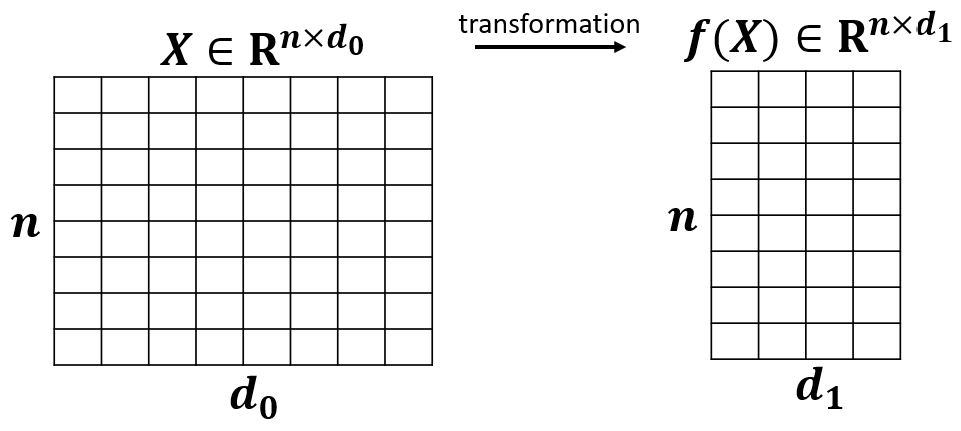
</div>

## Test dataset and model

First, we load an example databank from our **transmorph** API.

In [1]:
from transmorph.datasets import load_chen_10x

datasets = load_chen_10x()

databank_api > Loading bank chen_10x.
databank_api > Bank chen_10x successfully loaded.


Let us define a utilitary function, *create_model_transformation* which generates a very simplistic model composed of 3 layers (input, transformation, output), with the transformation layer endowed with a set of transformation algorithms passed as parameter. It will allow us to easily test transformation algorithms (they cannot be used outside of a model).

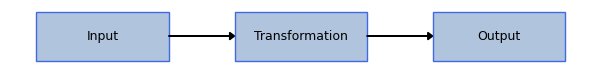

In [2]:
from transmorph.engine import Model
from transmorph.engine.layers import LayerInput, LayerTransformation, LayerOutput
from transmorph.utils.plotting import plot_model

def create_model_transformation(*transforms):
    # Creates a minimalist model endowed with a set of transformations
    
    # Initializes layers
    layer_input = LayerInput()
    layer_transformation = LayerTransformation()
    for t in transforms:
        layer_transformation.add_transformation(t)
    layer_output = LayerOutput()

    # Setup connections
    layer_input.connect(layer_transformation)
    layer_transformation.connect(layer_output)

    # Build model
    model = Model(input_layer=layer_input)
    return model

# Creating an empty model
plot_model(create_model_transformation())

## Common features reduction

Common features transformation is a simple algorithm that projects every dataset in the subspace of their common features. It takes care of both selecting common features, and reordering data matrix columns accordingly. It also expects the input representation to match AnnData.var dataframe in size.

<div>
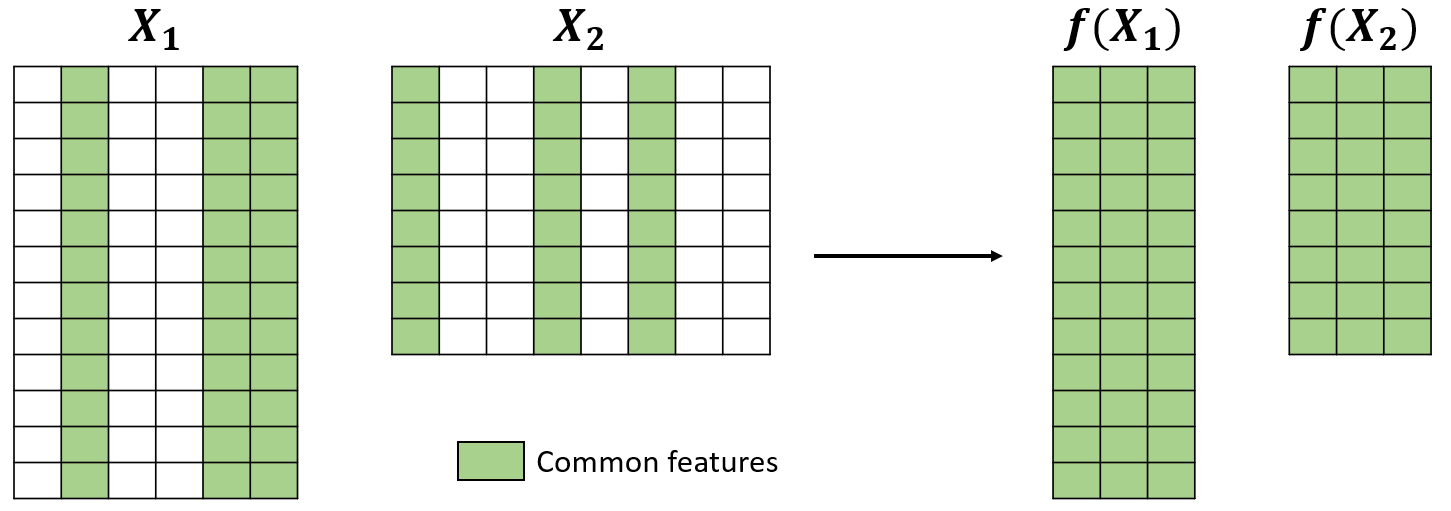
</div>

Let us first setup a simple model endowed with a common features reduction step.

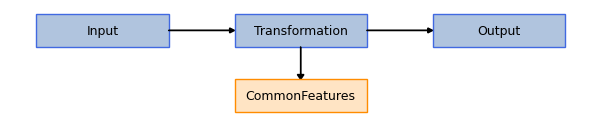

In [4]:
from transmorph.engine.transforming import CommonFeatures

model_cf = create_model_transformation(CommonFeatures())

plot_model(model_cf)

We can now launch the model on our dataset, and store its output under the "X_common_features" .obsm key within every AnnData object.

In [12]:
model_cf.fit(datasets, output_representation="X_common_features")

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 14 datasets, 61870 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#12.
CUSTOM_MODEL > Running layer LAYER_TRANSFORMATION#13.
CUSTOM_MODEL > Running layer LAYER_OUTPUT#14.
CUSTOM_MODEL > Terminated. Total embedding shape: (61870, 924)
CUSTOM_MODEL > Results have been written in AnnData.obsm['X_common_features'].


Let us quickly check the output shape.

In [13]:
for key in datasets:
    print(datasets[key].X.shape, '\t->', datasets[key].obsm['X_common_features'].shape)

(3829, 10000) 	-> (3829, 924)
(4633, 10000) 	-> (4633, 924)
(5677, 10000) 	-> (5677, 924)
(1295, 10000) 	-> (1295, 924)
(4030, 10000) 	-> (4030, 924)
(3874, 10000) 	-> (3874, 924)
(1087, 10000) 	-> (1087, 924)
(3970, 10000) 	-> (3970, 924)
(1945, 10000) 	-> (1945, 924)
(1864, 10000) 	-> (1864, 924)
(5769, 10000) 	-> (5769, 924)
(4496, 10000) 	-> (4496, 924)
(11210, 10000) 	-> (11210, 924)
(8191, 10000) 	-> (8191, 924)


We can see 924 common genes have been found across the datasets. All datasets are now embedded after this step within a common genes space, which for instance allows proximity-based methods to be used.

## Principal component analysis

Principal component analysis (PCA) is a commonly used linear dimensionality reduction method which projects data into an orthogonal base which maximizes the amount of variance. This is an almost mandatory step in pipelines dealing with high dimensionality objects such as single-cell RNA-seq datasets, as it greatly helps mitigating the curse of dimensionality which is an obstacle to most subsequent algorithms.

<div>
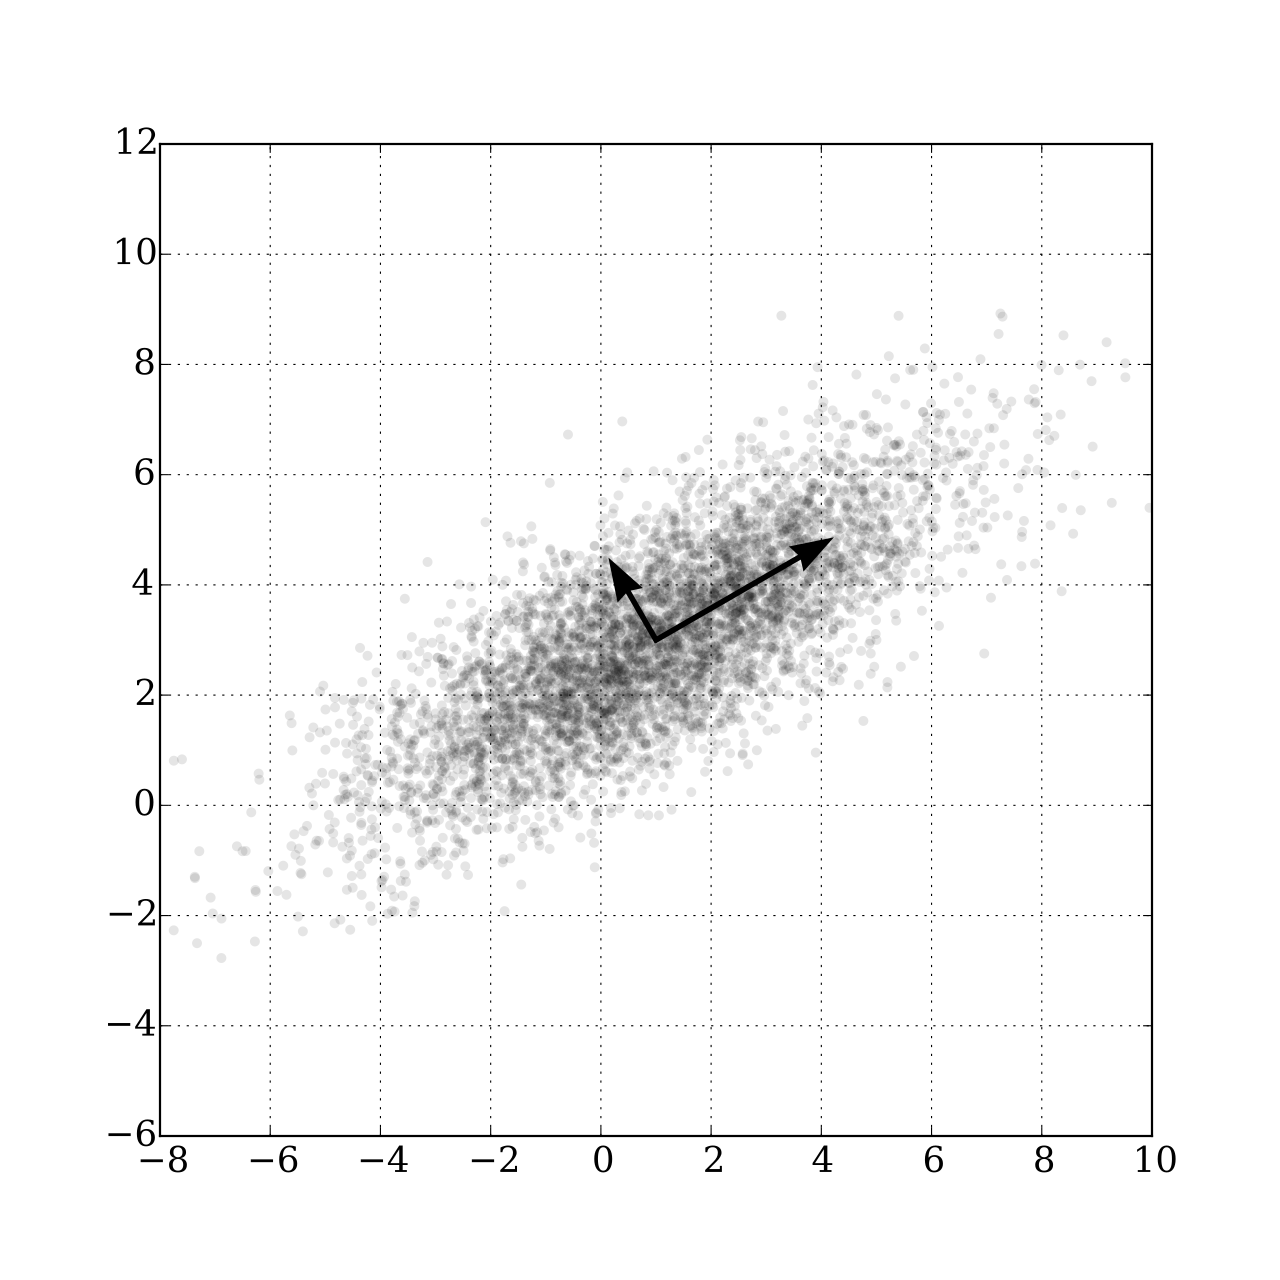
</div>

Let us first setup a simple model to carry out PCA on our datasets. Note that we first need to add a CommonFeatures step, as PCA must be conducted on datasets embedded in the same space to obtain comparable features. We choose here 2 components for the number of components to return as we would like to plot them, but in typical applications we use between 10 and 50 components.

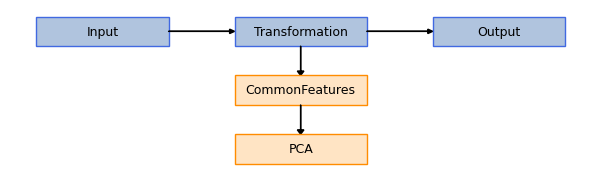

In [5]:
from transmorph.engine.transforming import PCA

model_pca = create_model_transformation(CommonFeatures(), PCA(n_components=2))

plot_model(model_pca)

We run here the model on our datasets, specifying "X_pca" as a key to store transformation results.

In [15]:
model_pca.fit(datasets, output_representation="X_pca")

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 14 datasets, 61870 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#15.
CUSTOM_MODEL > Running layer LAYER_TRANSFORMATION#16.
CUSTOM_MODEL > Running layer LAYER_OUTPUT#17.
CUSTOM_MODEL > Terminated. Total embedding shape: (61870, 2)
CUSTOM_MODEL > Results have been written in AnnData.obsm['X_pca'].


Let us check dimensionality of the output representation, to verify it is 2.

In [16]:
for key in datasets:
    print(datasets[key].X.shape, '\t->', datasets[key].obsm['X_pca'].shape)

(3829, 10000) 	-> (3829, 2)
(4633, 10000) 	-> (4633, 2)
(5677, 10000) 	-> (5677, 2)
(1295, 10000) 	-> (1295, 2)
(4030, 10000) 	-> (4030, 2)
(3874, 10000) 	-> (3874, 2)
(1087, 10000) 	-> (1087, 2)
(3970, 10000) 	-> (3970, 2)
(1945, 10000) 	-> (1945, 2)
(1864, 10000) 	-> (1864, 2)
(5769, 10000) 	-> (5769, 2)
(4496, 10000) 	-> (4496, 2)
(11210, 10000) 	-> (11210, 2)
(8191, 10000) 	-> (8191, 2)


We can easily plot the PCA result using transmorph, and observe our datasets jointly embedded in a low dimensional space. They would now be ready to be integrated!

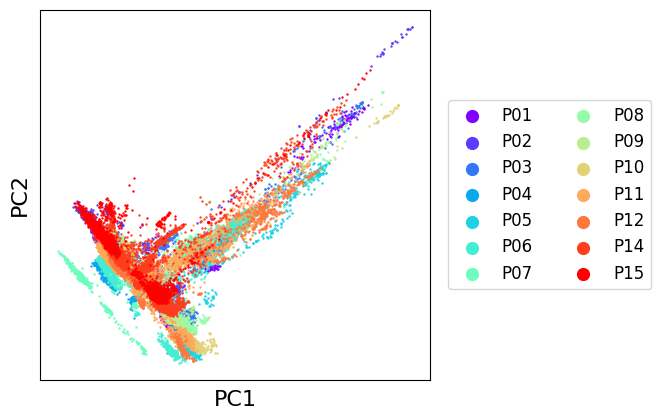

In [17]:
from transmorph.utils.plotting import scatter_plot

scatter_plot(datasets, use_rep='X_pca', xlabel='PC1', ylabel='PC2')

## Independent component analysis

Independent component analysis (ICA) is not properly speaking a dimensionality reduction method, but it can be used to do so. It is a matrix factorization method which deconvolutes a complex signal into a set of factors. For more details on ICA, see here: 

https://stabilized-ica.readthedocs.io/en/latest/ICA.html#definition-of-ica

<div>
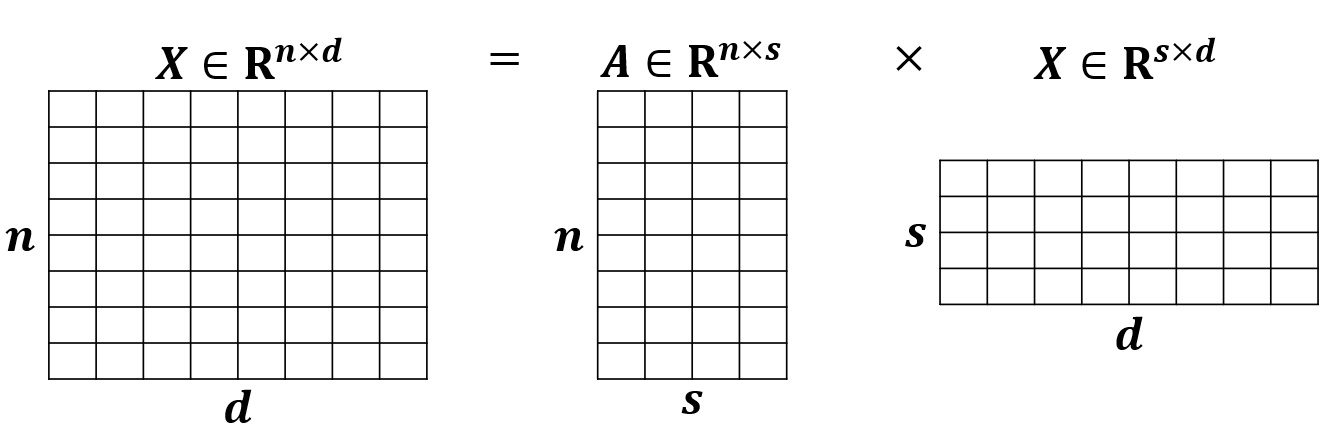
</div>

Note that the number of sources $s$ must be defined beforehand, and has an important impact on the output. We choose 2 here to be able to plot the $A$ matrix, but it is probably a suboptimal choice for this application.

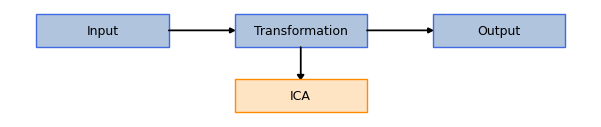

In [18]:
from transmorph.engine.transforming import ICA

model_ica = create_model_transformation(ICA(n_components=2))

plot_model(model_ica)

In [19]:
model_ica.fit(datasets, output_representation="X_ica")

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 14 datasets, 61870 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#18.
CUSTOM_MODEL > Running layer LAYER_TRANSFORMATION#19.
CUSTOM_MODEL > Running layer LAYER_OUTPUT#20.
CUSTOM_MODEL > Terminated. Total embedding shape: (61870, 2)
CUSTOM_MODEL > Results have been written in AnnData.obsm['X_ica'].


## Neighborhood-based pooling

Neighborhood-based pooling is a transformation step geared towards reducing noise within an embedding by averaging every cell to the value of its $k$-nearest neighbors. The more neighbors are used, the more fuzzy the result is. 

<div>
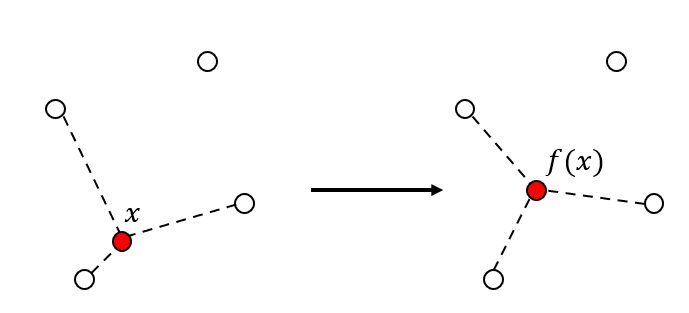
</div>

As this is a metric-based method, it is necessary to first embed datasets in a common feature space, then compute a dimensionality reduction of them to escape curse of dimensionality.

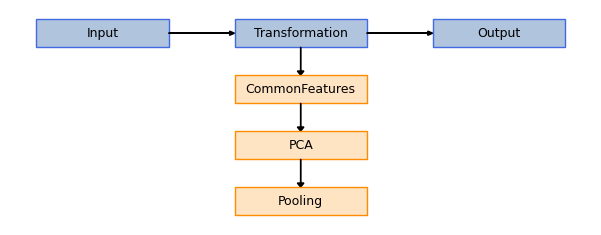

In [6]:
from transmorph.engine.transforming import Pooling

model_pooling = create_model_transformation(
    CommonFeatures(), 
    PCA(n_components=2), 
    Pooling(n_neighbors=5)
)

plot_model(model_pooling)

In [7]:
model_pooling.fit(datasets, output_representation="X_pooling")

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 14 datasets, 61870 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#9.
CUSTOM_MODEL > Running layer LAYER_TRANSFORMATION#10.
CUSTOM_MODEL > Running layer LAYER_OUTPUT#11.
CUSTOM_MODEL > Terminated. Total embedding shape: (61870, 2)
CUSTOM_MODEL > Results have been written in AnnData.obsm['X_pooling'].


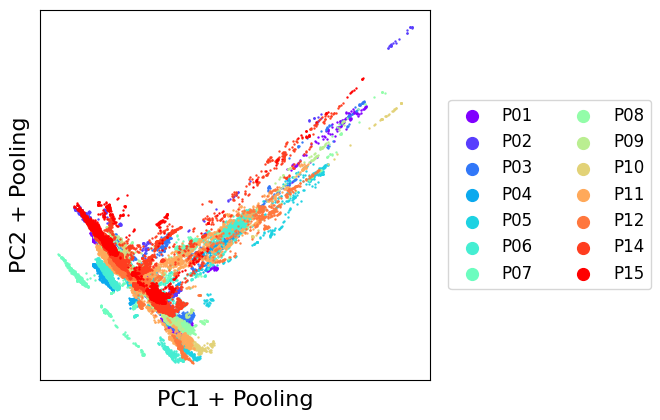

In [9]:
from transmorph.utils.plotting import scatter_plot

scatter_plot(datasets, use_rep='X_pooling', xlabel='PC1 + Pooling', ylabel='PC2 + Pooling')

As we can see, dots are more condensed than in the PCA-only projection. This is the effect of pooling.

## Creating a custom transformation module

In this final section, you will learn how to create a custom transformation module that can be used within any **transmorph** pipeline. Every module is implemented as an object whose attributes are parameters. Doing so, it is easy to add new algorithms by following a few specifications.

To illustrate this concept, let us implement a toy transformation module that adds a given value to every coefficient within an embedding matrix. We first have to define a new class that will operate this transformation, making it inherit from the transmorph.enging.transforming.Transformation abstract class. As stated previously, algorithm parameters can be passed to the constructor and stored as class attributes to be easily accessed during the computation.

Any transformation must implement at least two methods. *check_input*, which takes as input the set of embeddings to transform and which raises an exception if they are invalid. For instance, it can be used to check if all embeddings are in a feature space of the same size, or if all coefficients are nonnegative. 

The second method to implement is the *transform* method, which takes as input two lists sorted in the same order: the AnnData objects containing data to process, together with the embedding to transform provided as numpy arrays. There is no need to explicitly call *check_input* within the *transform* method, as this is taken care of by the **transmorph** engine. This method should carry out the necessary computations, and return a new list of embeddings as a transformation output.

In [16]:
from transmorph.engine.transforming import Transformation
from typing import List

import anndata as ad
import numpy as np

class TransformationPlusX(Transformation):
    """
    This is a simple custom transformation, which adds $add_x to every coefficient.
    
    Parameters
    ----------
    add_x: float
        Value to add.
    """
    
    def __init__(self, add_x: float):
        # We need to explicitly specify Transformation constructor,
        # as transmorph modules often use multiple inheritance.
        # We'll cover these advanced mechanisms in another tutorial.
        Transformation.__init__(
            self, 
            str_identifier="PlusX", # String name of module
            preserves_space=True # Is output same space as input?
        )
        self.add_x = add_x
        
    def check_input(self, datasets: List[np.ndarray]) -> None:
        """
        This method must be overriden. It can perform a checking over
        embeddings on which transformation will take place, to
        verify they all fulfill desired properties. If not, it can raise
        an exception. 
        
        Example: Only accepts embeddings of same features number.
        """
        assert all(X.shape[1] == datasets[0].shape[1] for X in datasets),\
            "All embeddings must be of same features size." 
    
    def transform(self, datasets: List[ad.AnnData], embeddings: List[np.ndarray]) -> List[np.ndarray]:
        """
        This method must be overriden. It takes as input in the same order the list
        of AnnData objects and the current embedding state (i.e. the one obtained after 
        the latest transformation). It must return a set of transformed embeddings in 
        the same order (better to return copies).
        """
        return [X + self.add_x for X in embeddings]

This module can then be directly implemented within a **transmorph** pipeline.

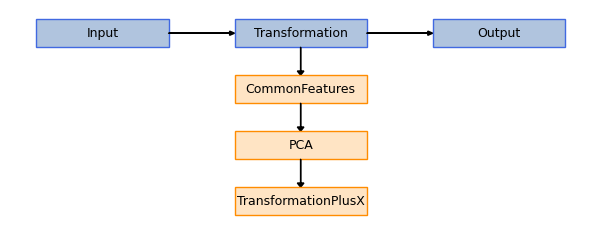

In [17]:
model_tpx = create_model_transformation(
    CommonFeatures(),
    PCA(n_components=2),
    TransformationPlusX(add_x=5.0)
)

plot_model(model_tpx)

In [18]:
model_tpx.fit(datasets, output_representation="X_plus_5")

CUSTOM_MODEL > Transmorph model is initializing.
CUSTOM_MODEL > Ready to start the integration of 14 datasets, 61870 total samples.
CUSTOM_MODEL > Running layer LAYER_INPUT#15.
CUSTOM_MODEL > Running layer LAYER_TRANSFORMATION#16.
CUSTOM_MODEL > Running layer LAYER_OUTPUT#17.
CUSTOM_MODEL > Terminated. Total embedding shape: (61870, 2)
CUSTOM_MODEL > Results have been written in AnnData.obsm['X_plus_5'].
